In [1]:
import datetime as dt
from IPython.display import display, JSON
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment
import os
from shutil import copy
import xarray as xr
import netCDF4 as nc4
import numpy as np
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

/Users/jmadams1/opt/anaconda3/envs/harmony-py/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# Construct Harmony requests 
def get_request(minLon, minLat, maxLon, maxLat, minTime, maxTime):
    request = Request(
        collection = Collection(id='C1692982075-GES_DISC'), # SNDRSNIML2CCPRET_2 in PROD
        variables=['/surf_air_temp','/surf_air_temp_qc'],   # These must have UMM-Var entries
        spatial = BBox(minLon, minLat, maxLon, maxLat),
        temporal = {'start': minTime, 'stop': maxTime},
    )
    if request.is_valid() is False:
        print('Invalid request')
        return False
    else:
        return request

In [2]:
# Submit Harmony requests, get back the file name of the downloaded result
def submit_request(request, name):
    # submit the job, save the jobID, print a URL to check job status in browser
    job_id = harmony_client.submit(request)
    print('https://harmony.earthdata.nasa.gov/jobs/'+job_id)

    # show the progress bar for the job, get the result URL
    harmony_client.wait_for_processing(job_id, show_progress=True)
    urls = harmony_client.result_urls(job_id, show_progress=True)

    # create a local subdir, download the results 
    dir_name = './sub_'+name
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    results = harmony_client.download_all(job_id, directory=dir_name, overwrite=True)

    # stash the file names for easy reference
    file_names = [f.result() for f in results]

    # return the list of filenames
    return file_names

In [42]:
def DrawColorbar(fig,ax,p,units):
    buf = 0.01 # space between right edge of plot and left edge of colorbar
    wid = 0.01 # width of colorbar
    pos = ax.get_position()
    cbx = pos.x1 + buf
    cby = pos.bounds[1]
    cbh = pos.bounds[3]
    cax = fig.add_axes([cbx, cby, wid, cbh])
    cb  = plt.colorbar(p, cax=cax)
    b = plt.title(units)
    
def plotThis(fname,label):
    f = nc4.Dataset(fname,'r')
    var  = f['surf_air_temp']
    qflg = f['surf_air_temp_qc']   
    lats = f['lat']
    lons = f['lon']

    # Quality flag meanings:
    # 0=best  1=good  2=do_not_use
    varQ = var[:]
    qf = qflg[:]
    np.place(varQ, qf>1, np.nan)

    myExtent = [-71,-46,-12,13]   
    myExtent = [-74,-46,-15,13]   # this includes area of Brazil shapefile

    # Draw a scatter plot
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.set_extent(myExtent)
    p = ax.scatter(lons[:], lats[:], c=varQ, cmap=plt.cm.Spectral_r, 
                   marker='.', s=150, transform=ccrs.PlateCarree())
    title = 'Surface Air Temperature (Quality Flag Applied) -- '+label
    b = plt.title(title)

    # Add coastlines and gridlines
    ax.coastlines(resolution="50m",linewidth=0.75)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.8, color='#555555', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    DrawColorbar(fig,ax,p,'Kelvin')
    f.close()

# PROD

In [5]:
harmony_client = Client(env=Environment.PROD)

In [30]:
# Global 
name = 'global'
minLon = -180
maxLon = 180
minLat = -90
maxLat = 90
minTime = dt.datetime(2015, 11, 2, 17, 18,  0)
maxTime = dt.datetime(2015, 11, 2, 17, 23, 59)

In [31]:
# Get the subset from Harmony
req = get_request(minLon, minLat, maxLon, maxLat, minTime, maxTime)
if req: 
    global_files = submit_request(req, name)

{'username': 'jmadams1', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2022-03-22T15:02:14.145Z', 'updatedAt': '2022-03-22T15:02:14.753Z', 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/83707992-8caf-4dd1-b9c7-037e464328ea?page=1&limit=2000', 'title': 'The current page', 'type': 'application/json', 'rel': 'self'}], 'request': 'https://harmony.earthdata.nasa.gov/C1692982075-GES_DISC/ogc-api-coverages/1.0.0/collections/%2Fsurf_air_temp,%2Fsurf_air_temp_qc/coverage/rangeset?forceAsync=true&subset=lat(-90%3A90)&subset=lon(-180%3A180)&subset=time(%222015-11-02T17%3A18%3A00%22%3A%222015-11-02T17%3A23%3A59%22)', 'numInputGranules': 2, 'jobID': '83707992-8caf-4dd1-b9c7-037e464328ea'}
https://harmony.earthdata.nasa.gov/jobs/83707992-8caf-4dd1-b9c7-037e464328ea


 [ Processing: 100% ] |###################################################| [|]


In [32]:
for fn in global_files: print(fn)

./sub_global/SNDR.SNPP.CRIMSS.20151102T1718.m06.g174.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4
./sub_global/SNDR.SNPP.CRIMSS.20151102T1712.m06.g173.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4


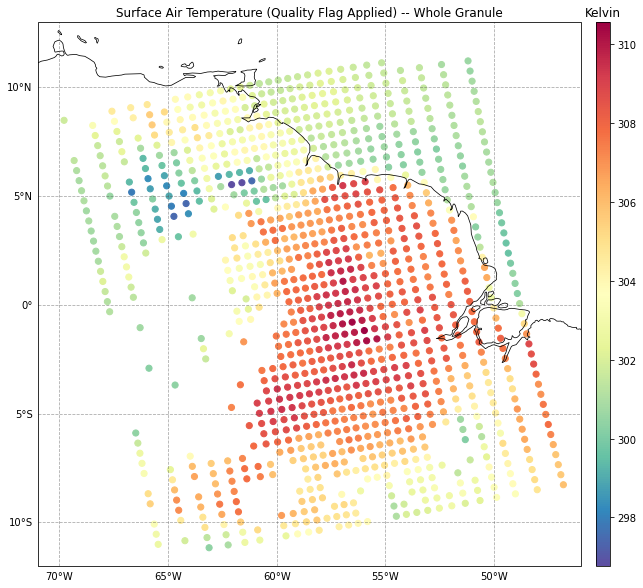

In [37]:
plotThis(global_files[0],'Whole Granule')

In [12]:
# Bounding Box 
name = 'bbox'
minLon = -60
maxLon = -55
minLat = 0
maxLat = 5
minTime = dt.datetime(2015, 11, 2, 17, 18,  2)
maxTime = dt.datetime(2015, 11, 2, 17, 23, 59)

In [13]:
# Get the subset from Harmony
req = get_request(minLon, minLat, maxLon, maxLat, minTime, maxTime)
if req: 
    bbox_files = submit_request(req, name)

{'username': 'jmadams1', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2022-03-22T14:53:48.359Z', 'updatedAt': '2022-03-22T14:53:48.359Z', 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/265a01bb-d9bb-4c34-89f6-29c8acf96724?page=1&limit=2000', 'title': 'The current page', 'type': 'application/json', 'rel': 'self'}], 'request': 'https://harmony.earthdata.nasa.gov/C1692982075-GES_DISC/ogc-api-coverages/1.0.0/collections/%2Fsurf_air_temp,%2Fsurf_air_temp_qc/coverage/rangeset?forceAsync=true&subset=lat(0%3A5)&subset=lon(-60%3A-55)&subset=time(%222015-11-02T17%3A18%3A02%22%3A%222015-11-02T17%3A23%3A59%22)', 'numInputGranules': 1, 'jobID': '265a01bb-d9bb-4c34-89f6-29c8acf96724'}
https://harmony.earthdata.nasa.gov/jobs/265a01bb-d9bb-4c34-89f6-29c8acf96724


 [ Processing: 100% ] |###################################################| [|]


In [14]:
for fn in bbox_files: print(fn)

./sub_bbox/SNDR.SNPP.CRIMSS.20151102T1718.m06.g174.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4


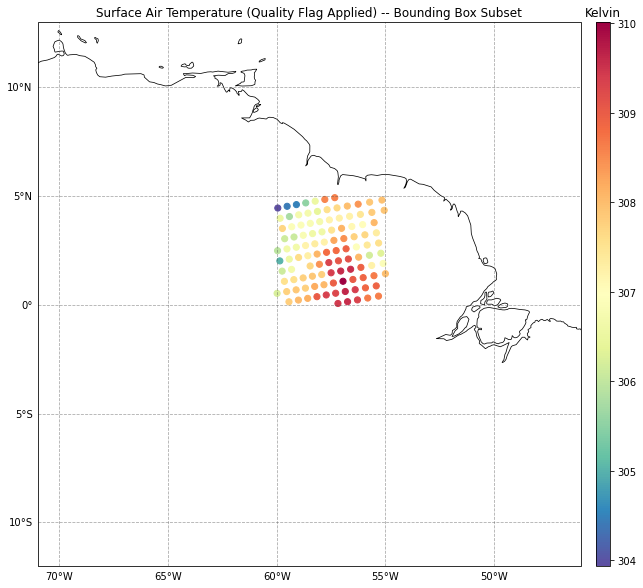

In [38]:
plotThis(bbox_files[0],'Bounding Box Subset')

In [16]:
# Time Slice 
name = 'time'
minLon = -71
maxLon = -46
minLat = -12
maxLat = 13
minTime = dt.datetime(2015, 11, 2, 17, 20, 0)
maxTime = dt.datetime(2015, 11, 2, 17, 22, 0)

In [17]:
# Get the subset from Harmony
req = get_request(minLon, minLat, maxLon, maxLat, minTime, maxTime)
if req: 
    time_files = submit_request(req, name)

{'username': 'jmadams1', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2022-03-22T14:57:19.750Z', 'updatedAt': '2022-03-22T14:57:19.750Z', 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/624d2a08-f3eb-49fb-86d1-5ee6d3fb6f16?page=1&limit=2000', 'title': 'The current page', 'type': 'application/json', 'rel': 'self'}], 'request': 'https://harmony.earthdata.nasa.gov/C1692982075-GES_DISC/ogc-api-coverages/1.0.0/collections/%2Fsurf_air_temp,%2Fsurf_air_temp_qc/coverage/rangeset?forceAsync=true&subset=lat(-12%3A13)&subset=lon(-71%3A-46)&subset=time(%222015-11-02T17%3A20%3A00%22%3A%222015-11-02T17%3A22%3A00%22)', 'numInputGranules': 1, 'jobID': '624d2a08-f3eb-49fb-86d1-5ee6d3fb6f16'}
https://harmony.earthdata.nasa.gov/jobs/624d2a08-f3eb-49fb-86d1-5ee6d3fb6f16


 [ Processing: 100% ] |###################################################| [|]


In [19]:
for fn in time_files: print(fn)

./sub_time/SNDR.SNPP.CRIMSS.20151102T1718.m06.g174.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4


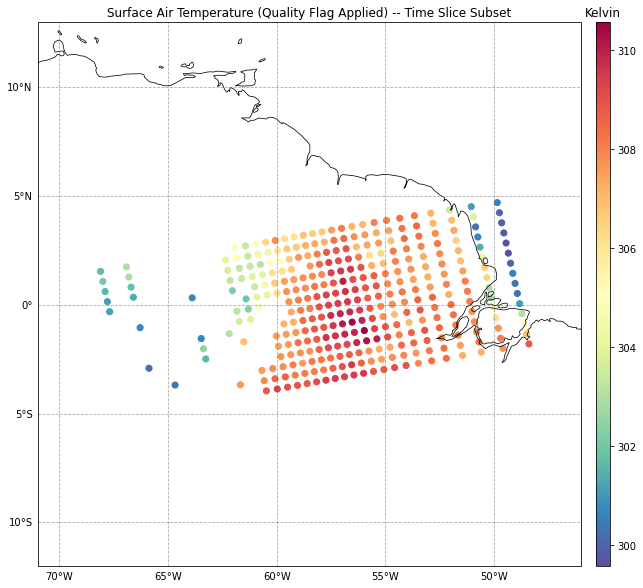

In [39]:
plotThis(time_files[0],'Time Slice Subset')

In [ ]:
file_names = [f.result() for f in results]

In [43]:
# Shapefile subset
name = 'shp'
minLon = -180
maxLon = 180
minLat = -90
maxLat = 90
minTime = dt.datetime(2015, 11, 2, 17, 18,  0)
maxTime = dt.datetime(2015, 11, 2, 17, 23, 59)

In [61]:
def get_request_shp(minLon, minLat, maxLon, maxLat, minTime, maxTime, shp_path=None):
    request = Request(
        collection = Collection(id='C1692982075-GES_DISC'), # SNDRSNIML2CCPRET_2 in PROD
        variables=['/surf_air_temp','/surf_air_temp_qc'],   # These must have UMM-Var entries
#        spatial = None,
        temporal = {'start': minTime, 'stop': maxTime},
        shape = '/Users/jmadams1/Shapefiles/test/16ME2500G.shp',
    )
    if request.is_valid() is False:
        print('Invalid request')
        return False
    else:
        return request

In [62]:
# Get the subset from Harmony
req = get_request_shp(minLon, minLat, maxLon, maxLat, minTime, maxTime, shp_path)
if req: 
    shape_files = submit_request(req, name)

Invalid request


In [50]:
req.shape

'/Users/jmadams1/Shapefiles/test/data.zip'

In [51]:
for fn in shape_files: print(fn)

./sub_shp/SNDR.SNPP.CRIMSS.20151102T1718.m06.g174.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4
./sub_shp/SNDR.SNPP.CRIMSS.20151102T1712.m06.g173.L2_CLIMCAPS_RET.std.v02_28.G.200331153124_subsetted.nc4


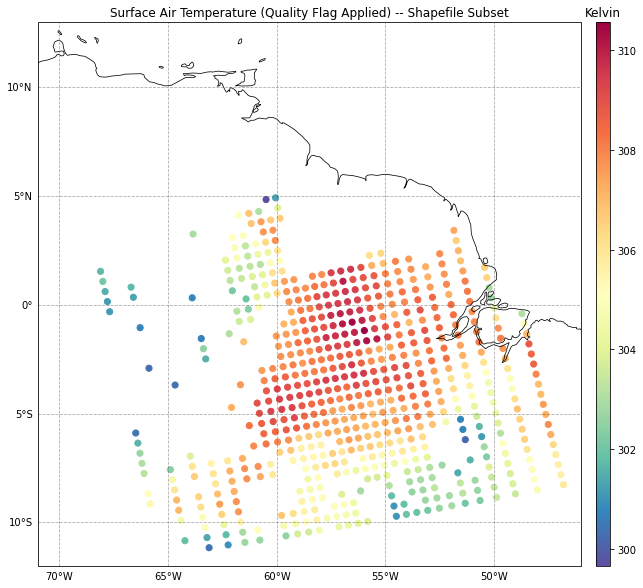

In [6]:
plotThis('/Users/jmadams1/GDDS/l2ss-py-main/shp_test_output.nc','Shapefile Subset')

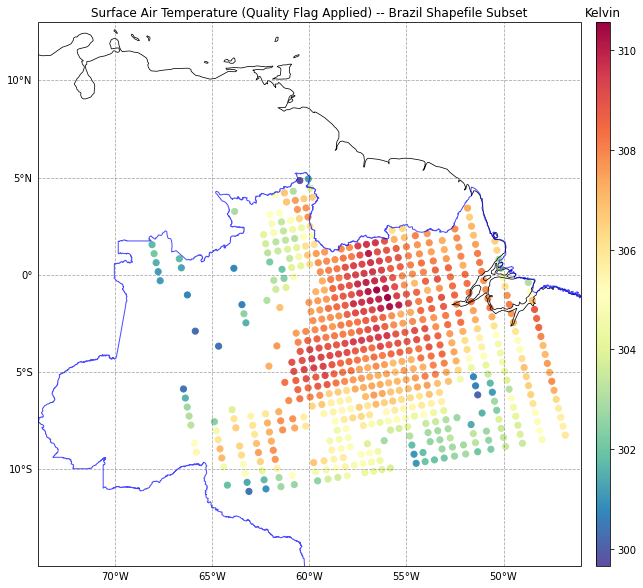

In [41]:
import shapefile as shp
import cartopy.io.shapereader as shpreader
sf = '/Users/jmadams1/Shapefiles/test/bra_admbnda_adm0_ibge_2020.shp'
shapes = list(shpreader.Reader(sf).geometries())

f = nc4.Dataset('/Users/jmadams1/GDDS/l2ss-py-main/shp_test_output.nc','r')
var  = f['surf_air_temp']
qflg = f['surf_air_temp_qc']   
lats = f['lat']
lons = f['lon']

# Quality flag meanings:
# 0=best  1=good  2=do_not_use
varQ = var[:]
qf = qflg[:]
np.place(varQ, qf>1, np.nan)

myExtent = [-82,-34,-40,12]   
myExtent = [-74,-46,-15,13]   

# Draw a scatter plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent(myExtent)
p = ax.scatter(lons[:], lats[:], c=varQ, cmap=plt.cm.Spectral_r, 
               marker='.', s=150, transform=ccrs.PlateCarree())
title = 'Surface Air Temperature (Quality Flag Applied) -- Brazil Shapefile Subset'
b = plt.title(title)

# Add coastlines, Brazil shapefile and gridlines
ax.coastlines(resolution="50m",linewidth=0.75)
ax.add_geometries(shapes, ccrs.PlateCarree(),edgecolor='blue',facecolor='none',alpha=0.7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.8, color='#555555', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
DrawColorbar(fig,ax,p,'Kelvin')
f.close()

In [18]:
sf.shapeRecords().

ShapeRecords: [<shapefile.ShapeRecord object at 0x7f88f1028eb0>]

In [66]:
!pwd

/Users/jmadams1
